# Cleaning Modes With Rational Filters

In [179]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [180]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries

## Data

Download data

In [181]:
home_dir = "./MDC_waveforms/"

In [182]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [183]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

In [184]:
len(H_data)

65536

In [185]:
H_peak = np.argmax(H_data)

In [186]:
start_time = H_data.times.value[H_peak]
t0 = H_data.times[H_peak]

(1126259461.9134278, 1126259462.2134278)

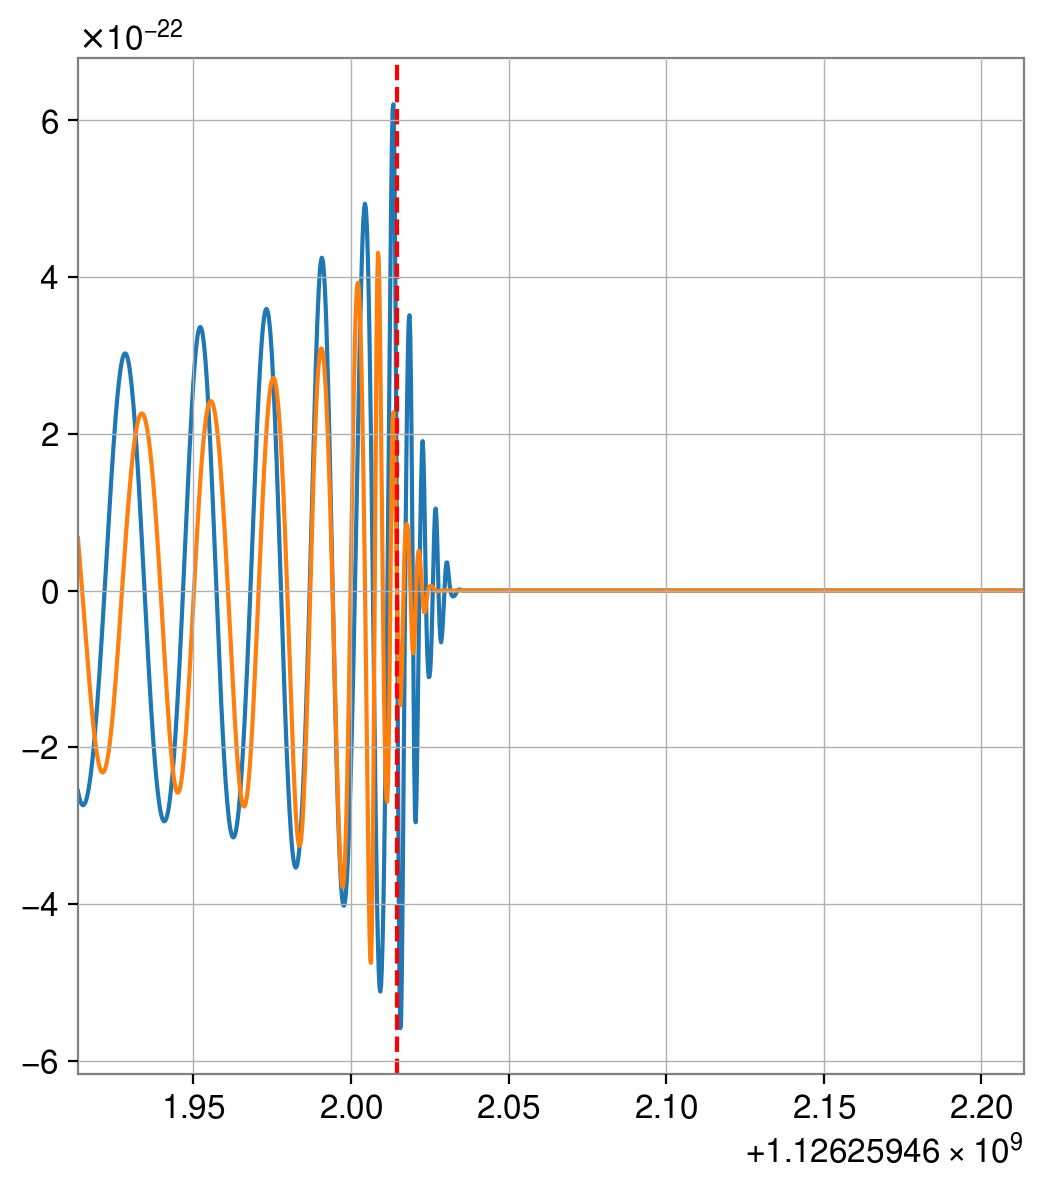

In [187]:
pl.plot(H_data.times, H_data.value)
pl.plot(L_data.times, L_data.value)
pl.axvline(start_time+1e-3, c = 'r', ls = '--')
pl.xlim(H_data.times.value[H_peak]-0.1, H_data.times.value[H_peak]+0.2)

## Noise

In [188]:
length = len(H_data.times)
noise = np.random.normal(0,1e-23,length)

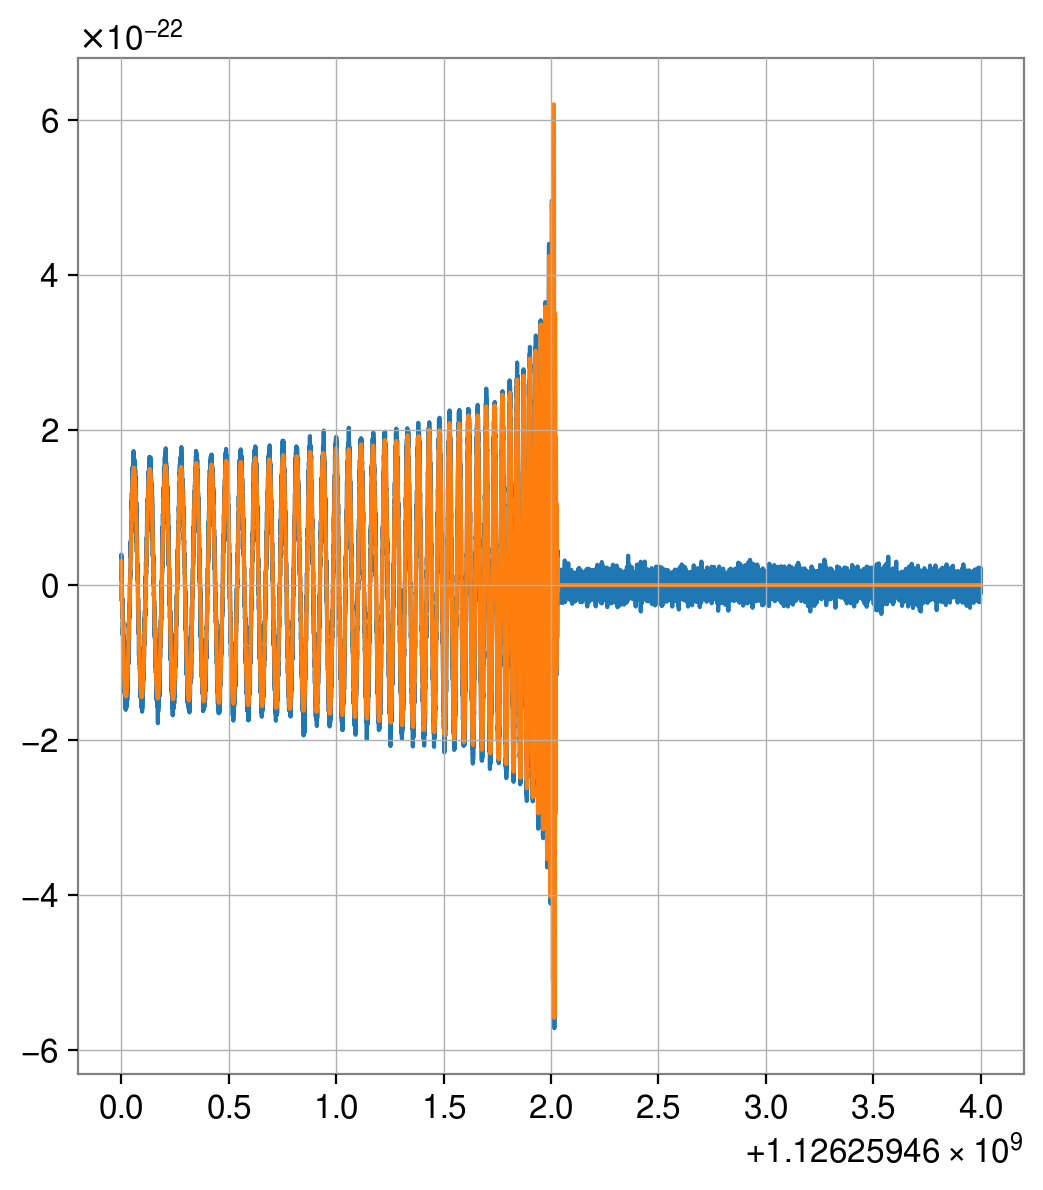

In [189]:
trim = int(3*len(H_data)/4)
pl.plot(H_data.times[trim:], H_data.value[trim:]+noise[trim:])
pl.plot(H_data.times[trim:], H_data.value[trim:])

In [190]:
H_waveform = qnm_filter.Data(H_data.value[trim:]+noise[trim:], index = H_data.times[trim:].value)
L_waveform = qnm_filter.Data(L_data.value[trim:]+noise[trim:], index = L_data.times[trim:].value)
noise_waveform = qnm_filter.Data(noise[trim:], index = L_data.times.value[trim:])

## Filter

In [191]:
fit = qnm_filter.Network(window_width=0.2, srate=4096, t_init = start_time+1e-3)

Load data

In [202]:
fit.original_data['H1'] = L_waveform
fit.detector_alignment()

In [203]:
fit.pure_noise = {}
fit.pure_noise['H1'] = noise_waveform
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
delta_mass = 0.4
delta_chi = 0.01
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

/home/neil/Dropbox/Ringdown/Codebase/qnm_filter/qnm_filter/Network.py:212: UserWarning: Overwriting ACFs
  warnings.warn("Overwriting ACFs")


In [204]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, model_list = [(2,2,0)])
credible_region = qnm_filter.find_credible_region(likelihood_data)

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

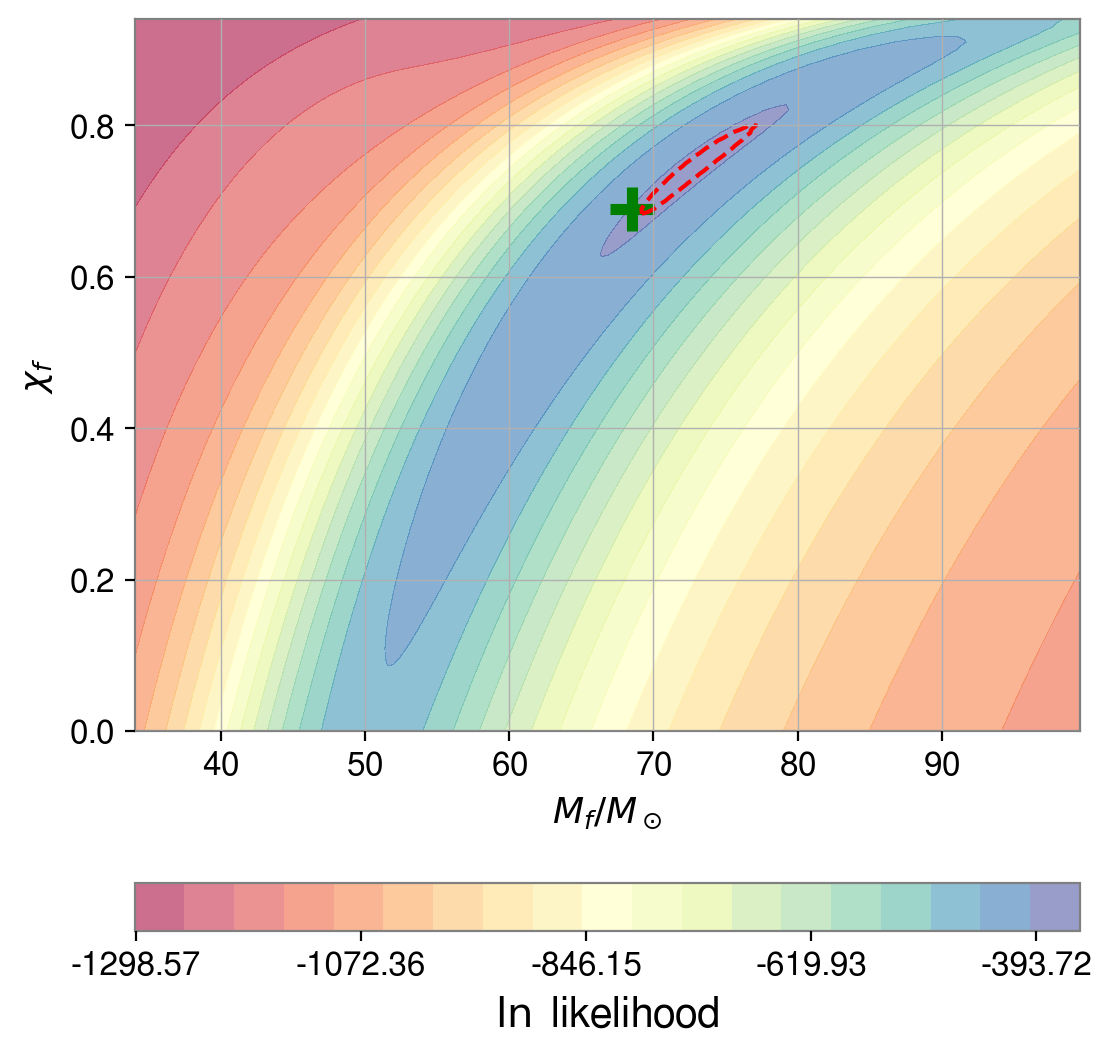

In [205]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')